In [38]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv("../data/private/0_raw_EbolaDatabase.csv")

In [28]:
if 'study_id' in df.columns:
    df.set_index('study_id', inplace=True)
df.head(0) # DO NOT PUSH A COMMIT WHERE ANY LINE IS VISIBLE!

,evd,evd_ct,malaria,death,sex,age,quarantine,days_admitted,referral_time,date_admis,...,hemoptysis_after,hematochezia_after,hematuria_after,gyne_hemorrhage_after,num_hemorrhage_sites_after,dehydration_after,hepatomegaly_after,jaundice_after,edema_after,splenomegaly_after
study_id,,,,,,,,,,,,,,,,,,,,,


In [31]:
print(df.shape)
# Show which columns contain any NA values:
df.isna().any().to_frame().T

(575, 66)


,evd,evd_ct,malaria,death,sex,age,quarantine,days_admitted,referral_time,date_admis,...,hemoptysis_after,hematochezia_after,hematuria_after,gyne_hemorrhage_after,num_hemorrhage_sites_after,dehydration_after,hepatomegaly_after,jaundice_after,edema_after,splenomegaly_after
0,False,True,True,False,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False


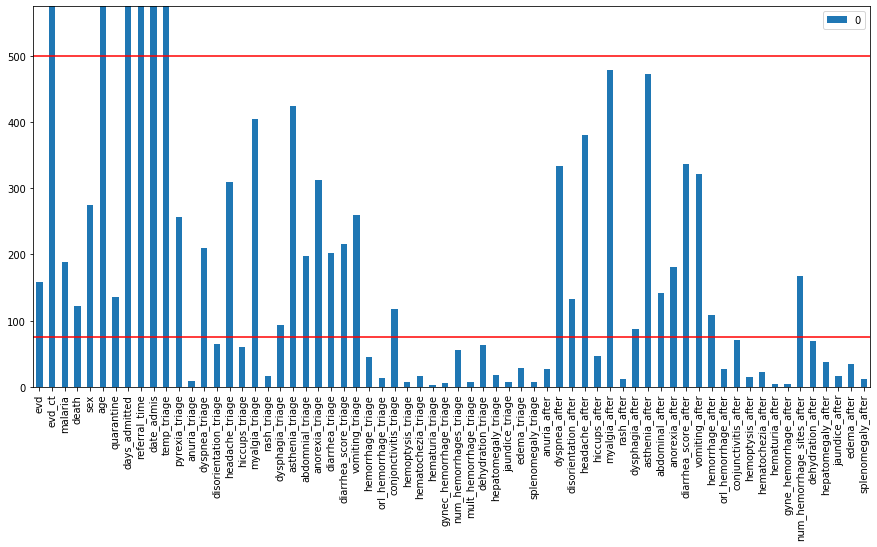

In [41]:
# Many columns are categorical. Let's count the positives:
df.sum().to_frame().plot(kind='bar', figsize=(15,7))
plt.gca().set_ylim((0, len(df)))
hline_limit = 75
plt.gca().axhline(y=hline_limit, color='r')
plt.gca().axhline(y=len(df) - hline_limit, color='r')
plt.show()

In [4]:
df[df.columns[df.isna().any()]].isna().sum().to_frame().T

,evd_ct,malaria,quarantine,referral_time
0,431,32,24,87


In [30]:
print("evd_ct is available for {ct} of the {pos} EVD+ patients.".format(
        ct=len(df) - df['evd_ct'].isna().sum(),
        pos=df['evd'].sum()
))

evd_ct is available for 144 of the 158 EVD+ patients.


The first four columns are the most obvious targets (`evd`, `evd_ct`, `malaria` and `death`).
The first three could be particularly useful in predicting `death`.

It appears that every patient admitted to the ETC was tested for Ebola (column `evd`).
`evd_ct` (inversely proportional to the viral load) is missing for all EVD- patients and for 14 EVD+ patients.
Malaria test results are missing for 32 patients.

One possibility for dealing with values missing not completely at random for continuous or ordered features, at least for ridge or logistic regression:

1. Standardize the features if you're going to use regularization (and why wouldn't you)
2. Add a one-hot encoded feature "feature_XY_is_na" (this feature should be non-zero when the other feature _is_ missing).
3. Replace the na values by 0.

Result: one weight learns what to contribute to the model when the feature is na, and another learns what to do when it is available. This could, for instance, result in different intercepts for people with vs without missing value, which makes sense if the values are missing for some systematic reason. It's kind of a backwards logic of "if the Doctor didn't deem it useful to perform this test, that's probably because the person was fine" or something.

Main downside: If the number of missing values is low, 

In [ ]:
df_std = 